# Importing libraries

In [1]:

import os
import sys

import numpy as np
import pandas as pd
from git_root import git_root
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
my_git_root = git_root()
sys.path.append(my_git_root)
from src import *

# Loading the data

In [2]:
df_chunked_path = f'{my_git_root}/data/output/documents_chunked_structured.csv'
df_chunked = pd.read_csv(df_chunked_path)

In [3]:
df_chunked

,name,text,num_tokens
0,aalto-university.md,Aalto University,3
1,aalto-university.md,Aalto University Research Data Management Policy,7
2,aalto-university.md,The research data management policy aims to ma...,89
3,aalto-university.md,The data management policy shall be implemente...,104
4,aalto-university.md,Ownership of copyright protected research data...,77
...,...,...,...
3481,wrexham-university.md,"FAIR Data\n\nWhere it is lawful to do so, the ...",96
3482,wrexham-university.md,Prifysgol Wrecsam Wrexham University\n\nPublic...,80
3483,wrexham-university.md,Reporting a Data Incident/Breach\n\nThe UK GDP...,125
3484,wrexham-university.md,"Other Polices, Procedures, Legislation\n\nThis...",51


In [4]:
documents = df_chunked['text'].to_list()
documents = [document.lower() for document in documents]

In [5]:
def keep_text_only(text):
    return re.sub(r'[^A-Za-z ]', '', text)

documents = [keep_text_only(document) for document in documents]

In [6]:
vectorizer = CountVectorizer(ngram_range=(2, 5))
doc_term_matrix = vectorizer.fit_transform(documents)

# Construct optimized model

In [7]:
lda_parameters = {
    'n_components': 24,
    'doc_topic_prior': 0.351257320684005,
    'topic_word_prior': 6.021283690090715,
    'learning_method': 'online',
    'random_state': 42,
}

lda = LatentDirichletAllocation(**lda_parameters)  # n_components = number of topics
lda = lda.fit(doc_term_matrix)

topic_document_matrix = lda.transform(doc_term_matrix)
topic_word_matrix = lda.components_
vocabulary = vectorizer.get_feature_names_out()

n_top_words = 1500
topic_descriptors = []
for topic_idx, topic_weights in enumerate(topic_word_matrix):
    # Get indices of the top n words for this topic
    top_word_indices = topic_weights.argsort()[-n_top_words:][::-1]
    # Map indices to tokens
    top_words = [vocabulary[i] for i in top_word_indices]
    topic_descriptors.append(top_words)

# Analyze topic Counts

In [8]:
dominant_topics = np.argmax(topic_document_matrix, axis=1)

data = {
    'Document': documents,
    'Dominant_Topic': dominant_topics
}
df = pd.DataFrame(data)


In [9]:
df

,Document,Dominant_Topic
0,aalto university,3
1,aalto university research data management policy,3
2,the research data management policy aims to ma...,3
3,the data management policy shall be implemente...,22
4,ownership of copyright protected research data...,3
...,...,...
3481,fair datawhere it is lawful to do so the unive...,22
3482,prifysgol wrecsam wrexham universitypublicly f...,3
3483,reporting a data incidentbreachthe uk gdpr req...,22
3484,other polices procedures legislationthis polic...,3


In [10]:
topic_counts = df['Dominant_Topic'].value_counts()

In [11]:
topic_counts

Dominant_Topic
3     1832
22    1421
0      110
19      13
10      11
12       9
13       7
1        7
17       7
11       7
20       6
14       6
5        6
18       5
8        5
23       5
7        4
4        4
2        4
9        4
16       4
21       4
15       3
6        2
Name: count, dtype: int64

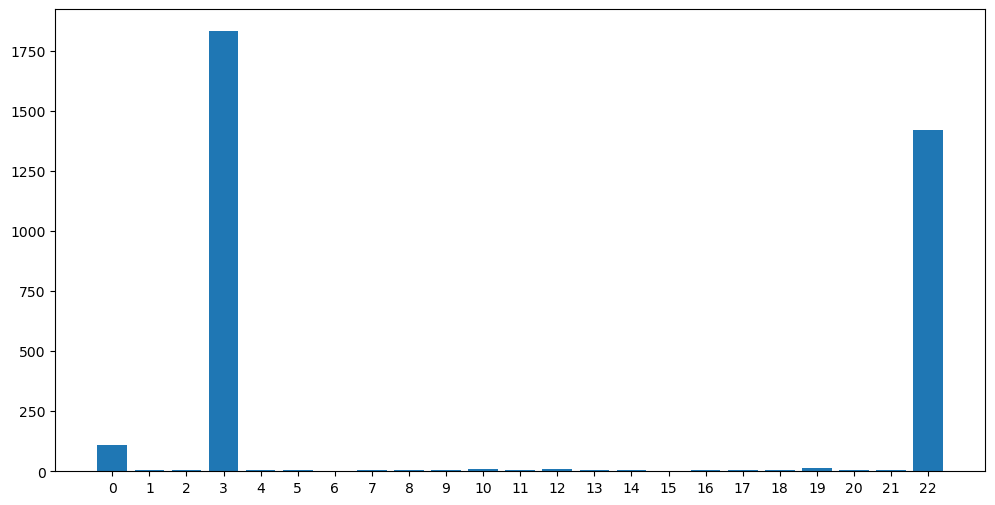

In [12]:
import matplotlib.pyplot as plt
import numpy as np

topic_indices = np.arange(0, len(topic_counts) - 1, 1)
topic_counts_graph = [topic_counts[i] for i in topic_indices]

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x=topic_indices, height=topic_counts_graph)
ax.set_xticks(topic_indices)
plt.savefig(f'{my_git_root}/notebooks/model_results/images/lda_harmonic_mean_topic_counts.svg')
plt.show()

In [13]:
np.mean(topic_counts)

145.25

In [14]:
np.std(topic_counts)

451.02117928836407

# Create interpretable topic names

In [15]:
interpretable_topic_names = {}

for topic_idx, topic in enumerate(lda.components_):
    interpretable_topic_names[topic_idx] = [vocabulary[i] for i in topic.argsort()[:-n_top_words - 1:-1]]

Remove stop-words and only show top 25 descriptors

In [16]:
def remove_stop_words(text):
    stop_words = stopwords.words('english')
    regex_stop_words = '|'.join(stop_words)
    result = re.sub(rf'^((?:{regex_stop_words})\s+)+', '', text)
    result = re.sub(rf'(\s+(?:{regex_stop_words}))+$', '', result)
    return result

In [17]:
def remove_single_words(topic_descriptors):
    result = []
    for topic_descriptor in topic_descriptors:
        if bool(re.search('\s+', topic_descriptor)):
            result.append(topic_descriptor)
    return result

In [18]:
def remove_duplicate_words(topic_descriptors):
    result = []

    for topic_descriptor in topic_descriptors:
        if topic_descriptor not in result:
            result.append(topic_descriptor)
    return result

In [19]:
def keep_top_n_topic_descriptors(topic_descriptors, n):
    return topic_descriptors[:n]

In [20]:
n = 25

for index, value in interpretable_topic_names.items():
    interpretable_topics = [remove_stop_words(topic) for topic in value]
    interpretable_topics = remove_single_words(interpretable_topics)
    interpretable_topics = remove_duplicate_words(interpretable_topics)
    interpretable_topics = keep_top_n_topic_descriptors(interpretable_topics, n)
    interpretable_topic_names[index] = interpretable_topics

In [21]:
for index, value in interpretable_topic_names.items():
    print(f'\\textbf{{Topic {index}}}:\n\n\\noindent\\textbf{{cTF-IDF representation: }}{", ".join(value)}\\\\\n\n\\noindent')

\textbf{Topic 0}:

\noindent\textbf{cTF-IDF representation: }indirectly identifying, directly and indirectly identifying, directly and indirectly, identifying data, indirectly identifying data, also definitions, anonymise the removal, data inthedatasetcaninnowaybetracedbacktoaperson, removal of directly and indirectly, removal of directly, see also definitions of directly, indirectly identifying characteristics, inthedatasetcaninnowaybetracedbacktoaperson see, directly and indirectly identifying characteristics, definitions of directly, inthedatasetcaninnowaybetracedbacktoaperson see also definitions, identifying characteristics such thatthe data, thatthe data inthedatasetcaninnowaybetracedbacktoaperson, indirectly identifying characteristics such thatthe, identifying characteristics, characteristics such thatthe data, thatthe data inthedatasetcaninnowaybetracedbacktoaperson see, see also definitions, thatthe data inthedatasetcaninnowaybetracedbacktoaperson see also, characteristics su